# CSE 4038 - Computer Vision in Health Care Lab

### Name: V Padmaja
### RegNo: 19BAI1107
### Lab Experiment 1: Noise and Filters

## Importing Necessary Libraries

In [1]:
import os
import numpy as np
from numpy.fft import fft2, ifft2
from scipy.signal import gaussian, convolve2d
import matplotlib.pyplot as plt

In [2]:
import cv2
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter
from skimage.util import random_noise
from skimage.color import rgb2gray
from skimage.color import gray2rgb
import skimage.io
from google.colab.patches import cv2_imshow

### Mounting the Drive

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Original Image

### Reading and Displaying the Image

In [4]:
image = cv2.imread('/content/gdrive/MyDrive/lena256.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

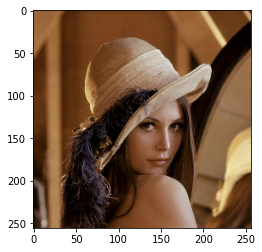

In [5]:
plt.imshow(image)

### Converting to GrayScale

Text(0.5, 1.0, 'Gray Scale')

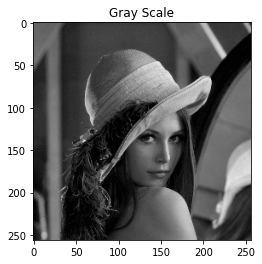

In [6]:
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap="gray")
plt.title("Gray Scale")

## Functions to add Noise

In [7]:
def noisy(noise_typ,image):
  if noise_typ == "gauss":
    gaussian_noise = random_noise(image, mode="gaussian")
    return gaussian_noise
  elif noise_typ == "s&p":
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.05
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    out[coords] = 0
    return out
  elif noise_typ == "poisson":
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy
  elif noise_typ =="speckle":
    row,col,ch = image.shape
    gauss = np.random.randn(row,col,ch)
    gauss = gauss.reshape(row,col,ch)        
    noisy = image + image * gauss
    return noisy

In [8]:
gauss=noisy("gauss",image)
#gauss.save('gauss_noise.png', 'PNG')
snp=noisy("s&p",image)
#gauss.save('s&p.png', 'PNG')
poisson=noisy("poisson",image)
#gauss.save('poisson.png', 'PNG')
speckle=noisy("speckle",image)
#gauss.save('speckle.png', 'PNG')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


## Visualizing Different Types of Noise on the image

Text(0.5, 1.0, 'Speckle Noise')

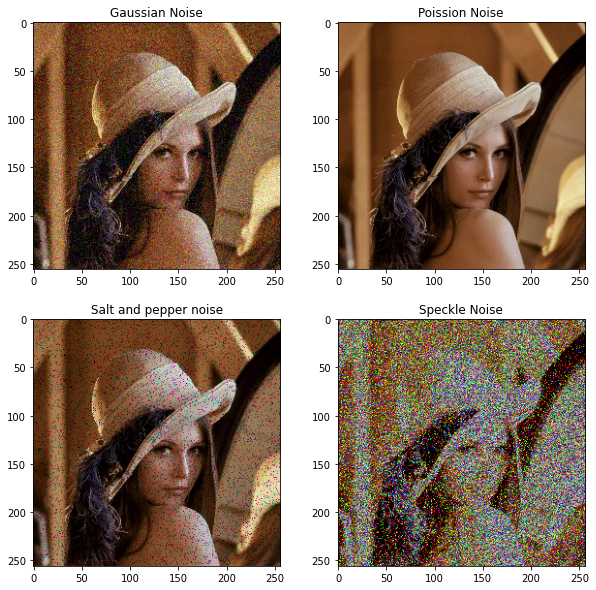

In [9]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))

ax[0][0].imshow(gauss, cmap='gray');
ax[1][0].imshow(snp.astype('uint8'));
ax[0][1].imshow(poisson.astype('uint8'));
ax[1][1].imshow(speckle.astype('uint8'));

ax[0][0].set_title('Gaussian Noise')
ax[1][0].set_title('Salt and pepper noise')
ax[0][1].set_title('Poission Noise')
ax[1][1].set_title('Speckle Noise')

#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9,top=0.6, wspace=0.1, hspace=0.1)

#### Weiner Filter to remove noise 

In [10]:
def wiener_filter(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = fft2(dummy)
    kernel = fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return dummy

In [11]:
def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

# Removing Noise using Filters

### Filters used:
- Mean Filter
- Gaussian Filter
- Median Filter
- Bilateral Filter
- Weiner Filter
    

## Removing Gaussian Noise

In [12]:
Mean_filter = cv2.blur(gauss,(5,5)) #kernel size 15 Avg
Gauss_Filter = cv2.GaussianBlur(gauss, (15, 15), 0) #kernel size 15
Median_Filter = cv2.medianBlur(np.float32(gauss), 5)
BilateralFilter = cv2.bilateralFilter(np.float32(gauss),4,75,75)

gauss_grey = rgb2gray(gauss)
kernel = gaussian_kernel(3)
filtered_img = wiener_filter(np.float32(gauss_grey), kernel, K = 30)

Text(0.5, 1.0, 'Weiner Filter')

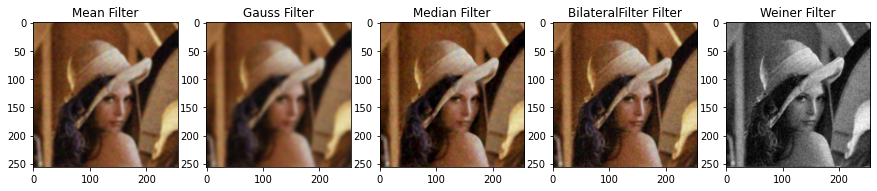

In [13]:
fig, ax = plt.subplots(1,5, figsize=(15,15))

ax[0].imshow(Mean_filter, cmap="gray");
ax[1].imshow(Gauss_Filter, cmap="gray");
ax[2].imshow(Median_Filter, cmap="gray");
ax[3].imshow(BilateralFilter, cmap="gray");
ax[4].imshow(filtered_img, cmap="gray");


ax[0].set_title('Mean Filter')
ax[1].set_title('Gauss Filter')
ax[2].set_title('Median Filter')
ax[3].set_title('BilateralFilter Filter')
ax[4].set_title('Weiner Filter')

### Inference: The median and Bilateral Filter seem to have performed better than the rest in removing Gaussian Noise

## Removing Poisson Noise

In [14]:
Mean_filter = cv2.blur(poisson,(5,5)) #kernel size 15 Avg
Gauss_Filter = cv2.GaussianBlur(poisson, (15, 15), 0) #kernel size 15
Median_Filter = cv2.medianBlur(np.float32(poisson), 5)
BilateralFilter = cv2.bilateralFilter(np.float32(poisson),9,75,75)

poisson_grey = rgb2gray(poisson)
kernel = gaussian_kernel(3)
filtered_img = wiener_filter(np.float32(poisson_grey), kernel, K = 30)

Text(0.5, 1.0, 'Weiner Filter')

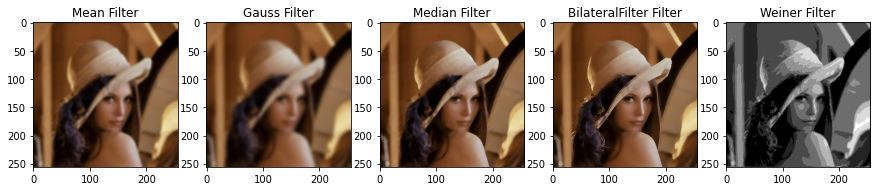

In [15]:
fig, ax = plt.subplots(1,5, figsize=(15,15))

ax[0].imshow(Mean_filter.astype('uint8'), cmap="gray");
ax[1].imshow(Gauss_Filter.astype('uint8'), cmap="gray");
ax[2].imshow(Median_Filter.astype('uint8'), cmap="gray");
ax[3].imshow(BilateralFilter.astype('uint8'), cmap="gray");
ax[4].imshow(filtered_img.astype('uint8'), cmap="gray");


ax[0].set_title('Mean Filter')
ax[1].set_title('Gauss Filter')
ax[2].set_title('Median Filter')
ax[3].set_title('BilateralFilter Filter')
ax[4].set_title('Weiner Filter')

### Inference: The Bilateral Filter seem to have performed best in removing Poisson Noise. It also seems to have enhanced the image

## Removing Salt and Pepper Noise

In [26]:
Mean_filter = cv2.blur(snp,(5,5)) #kernel size 15 Avg
Gauss_Filter = cv2.GaussianBlur(snp, (15, 15), 0) #kernel size 15
Median_Filter = cv2.medianBlur(np.float32(snp), 5)
BilateralFilter = cv2.bilateralFilter(np.float32(snp),9,75,75)

sandp_grey = rgb2gray(snp)
kernel = gaussian_kernel(3)
filtered_img = wiener_filter(np.float32(sandp_grey), kernel, K = 10)

Text(0.5, 1.0, 'Weiner Filter')

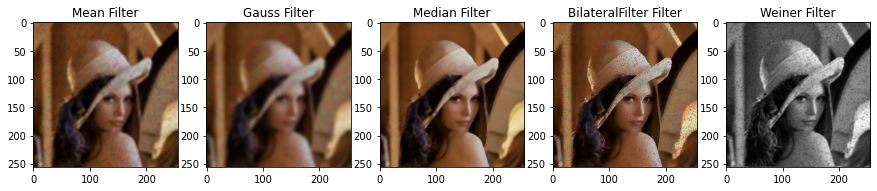

In [27]:
fig, ax = plt.subplots(1,5, figsize=(15,15))

ax[0].imshow(Mean_filter, cmap="gray");
ax[1].imshow(Gauss_Filter, cmap="gray");
ax[2].imshow(Median_Filter.astype('uint8'), cmap="gray");
ax[3].imshow(BilateralFilter.astype('uint8'), cmap="gray");
ax[4].imshow(filtered_img, cmap="gray");


ax[0].set_title('Mean Filter')
ax[1].set_title('Gauss Filter')
ax[2].set_title('Median Filter')
ax[3].set_title('BilateralFilter Filter')
ax[4].set_title('Weiner Filter')

### Inference: The median filter has performed well in removing Salt and Pepper Noise

## Removing Speckle Noise

In [22]:
Mean_filter = cv2.blur(speckle,(5,5)) #kernel size 15 Avg
Gauss_Filter = cv2.GaussianBlur(speckle, (15, 15), 0) #kernel size 15
Median_Filter = cv2.medianBlur(np.float32(speckle), 5)
BilateralFilter = cv2.bilateralFilter(np.float32(speckle),9,75,75)

speckle_grey = rgb2gray(speckle)
kernel = gaussian_kernel(3)
filtered_img = wiener_filter(np.float32(speckle_grey), kernel, K = 30)

Text(0.5, 1.0, 'Weiner Filter')

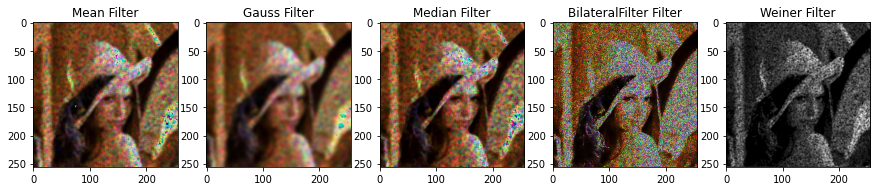

In [23]:
fig, ax = plt.subplots(1,5, figsize=(15,15))

ax[0].imshow(Mean_filter.astype('uint8'), cmap="gray");
ax[1].imshow(Gauss_Filter.astype('uint8'), cmap="gray");
ax[2].imshow(Median_Filter.astype('uint8'), cmap="gray");
ax[3].imshow(BilateralFilter.astype('uint8'), cmap="gray");
ax[4].imshow(filtered_img.astype('uint8'), cmap="gray");


ax[0].set_title('Mean Filter')
ax[1].set_title('Gauss Filter')
ax[2].set_title('Median Filter')
ax[3].set_title('BilateralFilter Filter')
ax[4].set_title('Weiner Filter')

### Inference: Speckle noise is prominent and has not reduced to a great extent in all the 5 filters. However the mean, median, bilateral and weiner filter have performed considerably well.